In [3]:
!pip install munch

In [1]:
import jax.numpy as jnp
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from jax import jacfwd, vmap, jit, device_get, lax
from jax.scipy.stats import norm
import munch

In [3]:
x_d1 = 1.5
x_d2 = -1.5

In [4]:
class TwoPopulationMFG(object):
    def __init__(self, T, Nt, xl, xr, N, nu, alphas, sigmas, lambdas, eps):
        self.T = T
        self.Nt = Nt
        self.xl = xl
        self.xr = xr
        self.N = N
        self.nu = nu
        self.alphas = alphas
        self.sigmas = sigmas
        self.lambdas = lambdas
        self.dt = T / Nt
        self.dx = (xr - xl) / N
        self.x_grid = jnp.linspace(xl, xr, N)
        self.t_grid = jnp.linspace(0, T, Nt)
        self.eps = eps
        self.h = (xr - xl) / N

    def mu0(self, x, population_index): # uncomment the commented 3 lines in both if and else statements to have initial normal distribution
        if population_index == 0:
            # return jnp.ones(x.shape) / (self.xr - self.xl)
            midpoint = (self.xr + self.xl) / 2
            sigma_mu = 1  # Define your standard deviation
            return norm.pdf(x, loc=midpoint, scale=sigma_mu)
        elif population_index == 1:
            midpoint = (self.xr + self.xl) / 2
            sigma_mu = 1  # Define your standard deviation
            return norm.pdf(x, loc=midpoint, scale=sigma_mu)
            # return jnp.ones(x.shape) / (self.xr - self.xl)

    def uT(self, x, population_index):
        if population_index == 0:
            return (x - x_d1) ** 2  # For population 1
        elif population_index == 1:
            return (x - x_d2) ** 2  # For population 2


    def local_kernel(self, x, y):
        # Calculate the Euclidean distance between two points
        distance = jnp.linalg.norm(x - y)
        # Return 1 if the distance is less than or equal to epsilon, else return 0
        return jnp.where(distance <= self.eps, 1, 0)

    def psi(self, Xtk, y, lambda_r, mu_k_t, mu_r_t, sigma_k):
        numerator = self.local_kernel(Xtk, y)

        denominator_terms = []


        distances = self.K_d(mu_k_t, mu_r_t, sigma_k)
        # distances = 0
        # Sum over the integral term, which we approximate with a sum over samples

        integral_approx = jnp.sum(self.local_kernel(Xtk, y)) / self.N
        denominator_terms.append(jnp.maximum(lambda_r  * integral_approx * distances, sigma_k))
        denominator = jnp.sum(jnp.array(denominator_terms))

        return numerator / denominator


    def prolong(self, Uvec, Mvec, idx):
        Umtx = jnp.reshape(Uvec, (self.Nt, self.N))
        Mmtx = jnp.reshape(Mvec, (self.Nt, self.N))

        U = jnp.zeros((self.Nt + 1, self.N))
        M = jnp.zeros((self.Nt + 1, self.N))

        U = U.at[:self.Nt, :].set(Umtx)
        M = M.at[1:, :].set(Mmtx)

        M0 = self.mu0(self.x_grid, idx)  # Assuming mu0 returns an array of shape (N,)
        UT = vmap(self.uT, in_axes=(0, None))(self.x_grid, idx)
        U = U.at[self.Nt, :].set(UT)
        M = M.at[0, :].set(M0)
        return U, M

    def K_d(self, x, y, sigma):
        mu_k_t_cumsum = jnp.cumsum(x)
        mu_r_t_cumsum = jnp.cumsum(y)

        w_p = jnp.sum(jnp.abs(mu_k_t_cumsum - mu_r_t_cumsum))

        kernel_values = jnp.where(w_p <= sigma, jnp.exp(-w_p), 0)
        # print("w_p_values:--------", kernel_values)

        return kernel_values

    def G_m(self, x, mu, population_index):
        """
        Calculate the G_M function for a given population.

        Parameters:
        x (array): Spatial grid points.
        mu (list of arrays): Distributions of each population.
        population_index (int): Index of the population.

        Returns:
        array: Computed G_M values for each point in x.
        """

        alpha_k = self.alphas[population_index]
        sigma_k = self.sigmas[population_index]
        # Calculate the interaction term
        interaction_term = jnp.zeros_like(x)
        for r, lambda_r in enumerate(self.lambdas):
            mu_r = mu[r]
            K_d_value = self.K_d(mu[population_index], mu_r, sigma_k)
            # K_d_value = 0
            psi_values = vmap(lambda y: self.psi(x, y, lambda_r, mu[population_index], mu_r, sigma_k) * y)(self.x_grid)


            # Approximate the integral as the sum of areas of rectangles
            integral_approximation = jnp.sum(psi_values) / self.N
            interaction_term += lambda_r  * integral_approximation * K_d_value

        # Calculate G_M
        G_M_value = alpha_k * interaction_term

        return G_M_value

    def g(self, x, q1, q2, m, idx):
        p1 = jnp.minimum(q1, 0)
        p2 = jnp.maximum(q2, 0)
        g_m = self.G_m(x, m, idx)

        b1 = jnp.minimum(g_m, 0)
        b2 = jnp.maximum(g_m, 0)

        return (p1 ** 2) / 2 + (p2 ** 2) / 2 + b1 * q1 + b2 * q2

    def hamilton(self, U, M, idx):
        dUR = (jnp.roll(U, -1) - U)/self.h
        dUL = (U - jnp.roll(U, 1))/self.h
        Hamiltonian = vmap(lambda x, q1, q2: self.g(x, q1, q2, M, idx))(self.x_grid, dUR, dUL)

        return Hamiltonian

    def hjb(self, ts, Uk1, Uk, Mk1, idx):
        UR = jnp.roll(Uk, -1)
        UL = jnp.roll(Uk, 1)

        Delta_U = - (2 * Uk - UR - UL) / self.h ** 2

        Dt_U = (Uk1 - Uk) / self.dt

        Hamiltonian = self.hamilton(Uk, Mk1, idx)

        return -Dt_U - self.nu * Delta_U + Hamiltonian - Mk1

    def fp_linearized_part(self, U, M, idx):
        UR = (jnp.roll(U, -1) - U) / self.h
        UL = (U - jnp.roll(U, 1)) / self.h

        URF = UR.flatten()
        ULF = UL.flatten()

        dGq1 = lambda x1, q1, q2: jnp.minimum(q1, 0)
        dGq2 = lambda x1, q1, q2: jnp.maximum(q2, 0)

        dGq1s = vmap(dGq1)(self.x_grid, URF, ULF)
        dGq2s = vmap(dGq2)(self.x_grid, URF, ULF)

        dGq1s = jnp.multiply(dGq1s, M)
        dGq2s = jnp.multiply(dGq2s, M)

        dGqDifference1 = dGq1s - dGq2s

        dGqs2R = jnp.roll(dGq2s, -1)
        dGqs1L = jnp.roll(dGq1s, 1)

        A = - (dGqDifference1 + dGqs2R - dGqs1L) / self.h

        b = vmap(lambda x: self.G_m(x, M, idx))(self.x_grid)
        bp1 = lambda x: jnp.minimum(x, 0)
        bp2 = lambda x: jnp.maximum(x, 0)

        bp1s = vmap(bp1)(b)
        bp2s = vmap(bp2)(b)

        bp1s = jnp.multiply(bp1s, M)
        bp2s = jnp.multiply(bp2s, M)

        bpDifference1 = bp1s - bp2s

        bp2sR = jnp.roll(bp2s, -1)
        bp1sL = jnp.roll(bp1s, 1)

        B = - (bpDifference1 + bp2sR - bp1sL) / self.h

        MEQByHands = A + B

        return MEQByHands


    def solve_hjb(self, U0, M, lr, idx, tol=10**(-6), epoch=100):
        error = 1
        iter_num = 0

        U = U0
        while error > tol and iter_num < epoch:
            b = self.hjb_sys_vec(U, M, idx)
            jacobi = jacfwd(self.hjb_sys_vec)(U, M, idx)
            dz = jnp.linalg.solve(jacobi, b.flatten())
            U = U - lr * dz

            error = jnp.dot(dz, dz)
            print("             the error of solving hjb is {}".format(error))

            iter_num = iter_num + 1

        return U


    def fp(self, Uk, Mk1, Mk, idx):
        Dt_M = (Mk1 - Mk) / self.dt

        Mk1R = jnp.roll(Mk1, -1)
        Mk1L = jnp.roll(Mk1, 1)

        Delta_M = - (2 * Mk1 - Mk1R - Mk1L) / self.h**2

        adj = self.fp_linearized_part(Uk, Mk1, idx)

        return Dt_M - self.nu * Delta_M + adj

    def solve_fp(self, M0, U1, U2):
        jacobi = jacfwd(self.fp_sys_vec)(M0, U1, U2)
        b = self.fp_sys_vec(jnp.zeros(len(jacobi)), U1, U2)
        M = jnp.linalg.lstsq(jacobi, -b)
        return M[0]

    def hjb_sys(self, U, M, idx):
        ts = jnp.linspace(0, self.T, self.Nt + 1)
        hjbs = vmap(self.hjb, in_axes=(0, 0, 0, 0, None))(ts[:-1], U[1:, :], U[:-1, :], M[1:, :], idx)
        return hjbs

    def fp_sys(self, U, M, idx):
        fps = vmap(self.fp, in_axes=(0, 0, 0, None))(U[:-1, :], M[1:, :], M[:-1, :], idx)

        return fps


    def hjb_sys_vec(self, Uvec, Mvec, idx):
        U, M = self.prolong(Uvec, Mvec, idx)
        return self.hjb_sys(U, M, idx).flatten()

    def fp_sys_vec(self, Mvec, Uvec, idx):
        U, M = self.prolong(Uvec, Mvec, idx)

        return self.fp_sys(U, M, idx).flatten()


    def solve(self, tol=10**(-6), epoch=100, hjb_lr=1, hjb_epoch=100):
        U1 = jnp.zeros((self.Nt, self.N)).flatten()
        U2 = jnp.zeros((self.Nt, self.N)).flatten()
        M1 = jnp.zeros((self.Nt, self.N)).flatten()
        M2 = jnp.zeros((self.Nt, self.N)).flatten()

        error = 1
        iter_num = 0

        while error > tol and iter_num < epoch:
            new_U1 = self.solve_hjb(U1, M1, hjb_lr, epoch=hjb_epoch, idx=0)
            new_U2 = self.solve_hjb(U2, M2, hjb_lr, epoch=hjb_epoch, idx=1)
            new_M1 = self.solve_fp(M1, new_U1, 0)
            new_M2 = self.solve_fp(M2, new_U2, 1)

            U_err = jnp.dot(new_U1 - U1, new_U1 - U1) + jnp.dot(new_U2 - U2, new_U2 - U2)
            M_err = jnp.dot(new_M1 - M1, new_M1 - M1) + jnp.dot(new_M2 - M2, new_M2 - M2)
            error = U_err + M_err

            print('MFG error: {}'.format(error))

            U1, U2, M1, M2 = new_U1, new_U2, new_M1, new_M2
            iter_num += 1

        U1, M1 = self.prolong(U1, M1, 0)
        U2, M2 = self.prolong(U2, M2, 1)

        return U1, M1, U2, M2

In [5]:
np.set_printoptions(precision=20)

In [12]:
cfg = munch.munchify({
    'T' : 1,
    'Nt': 50,
    'xl': -5,
    'xr': 5,
    'N' : 50,
    'nu': 1,
    'alphas': [0.5, 0.5],
    'sigmas': [1, 1],
    'lambdas':[0.5, 0.5],
    'eps': 1,
    'hjb_epoch': 200,
    'hjb_lr': 1,
    'epoch': 150,
    'lr': 0.7,
    'tol' : 10 ** (-6),
})

#T, Nt, xl, xr, N, nu, alphas, sigmas, lambdas, eps

solver = TwoPopulationMFG(T=cfg.T, Nt=cfg.Nt, xl=cfg.xl, xr=cfg.xr, N=cfg.N, nu=cfg.nu, alphas=cfg.alphas, sigmas=cfg.sigmas, lambdas=cfg.lambdas, eps=cfg.eps)

TT = jnp.linspace(0, cfg.T, cfg.Nt + 1)
XX = jnp.linspace(cfg.xl, cfg.xr, cfg.N, endpoint=False)
TT, XX = jnp.meshgrid(TT, XX)

# U, M = solver.solve_mfg(cfg.lr, cfg.tol, cfg.epoch)
U1, M1, U2, M2 = solver.solve(cfg.tol, cfg.epoch, cfg.hjb_lr, cfg.hjb_epoch)



2024-10-17 14:40:54.263935: W external/xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 590.8KiB (rounded to 605184)requested by op 
2024-10-17 14:40:54.264674: W external/xla/xla/tsl/framework/bfc_allocator.cc:508] ****************************************************************************************************
E1017 14:40:54.264737    6591 pjrt_stream_executor_client.cc:3084] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 605000 bytes.


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 605000 bytes.

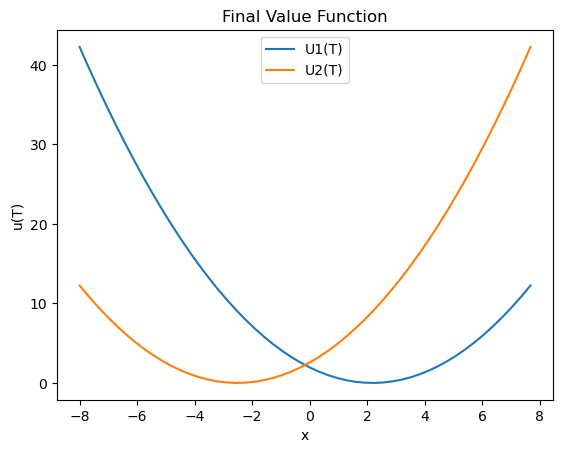

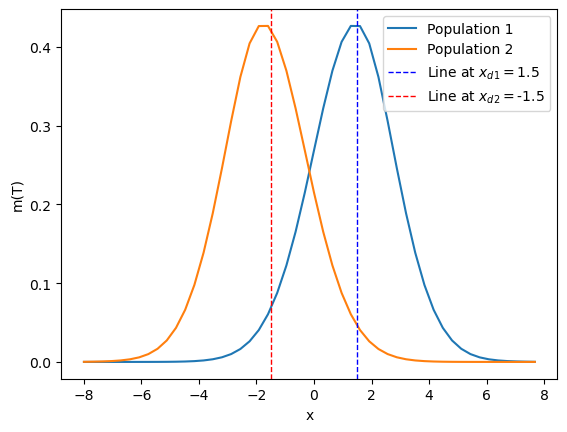

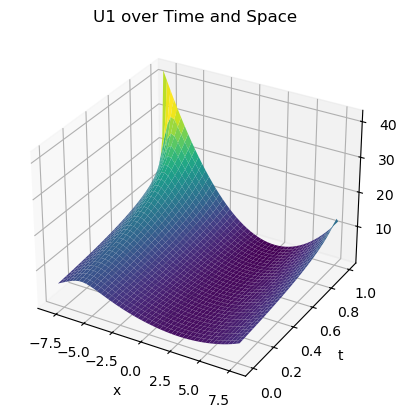

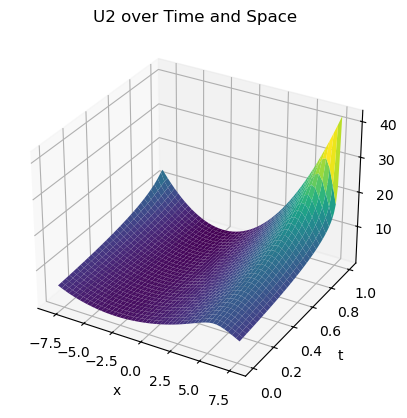

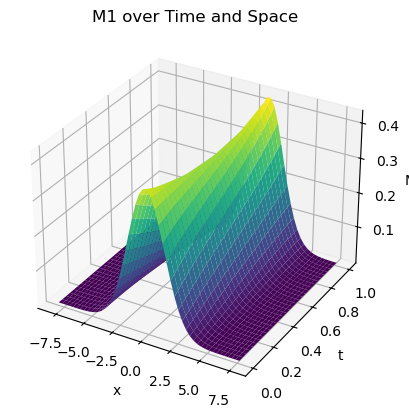

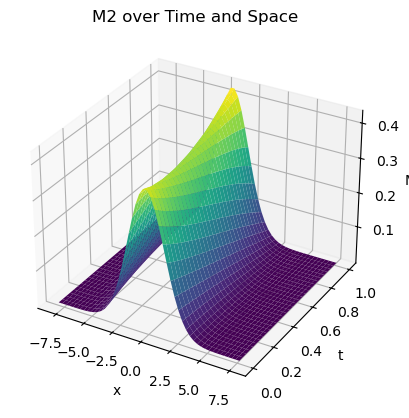

In [7]:

# Assuming cfg, U1, U2, M1, M2, x_d1, and x_d2 are already defined
TT = np.linspace(0, cfg.T, cfg.Nt + 1)
XX = np.linspace(-8, 8, cfg.N, endpoint=False)

# Final value function for both populations
plt.figure()
plt.plot(XX, U1[-1, :], label='U1(T)')
plt.plot(XX, U2[-1, :], label='U2(T)')
plt.title('Final Value Function')
plt.xlabel('x')
plt.ylabel('u(T)')
plt.legend()
plt.show()

# Final distribution for both populations with updated legends
plt.figure()
plt.plot(XX, M1[-1, :], label='Population 1')  # More descriptive name for M1(T)
plt.plot(XX, M2[-1, :], label='Population 2')  # More descriptive name for M2(T)
plt.axvline(x=x_d1, color='Blue', linestyle='--', linewidth=1, label=r'Line at $x_{d1}=$' + f'{x_d1}')  # LaTeX for subscript
plt.axvline(x=x_d2, color='Red', linestyle='--', linewidth=1, label=r'Line at $x_{d2}=$' + f'{x_d2}')  # LaTeX for subscript
plt.xlabel('x')
plt.ylabel('m(T)')
plt.legend(loc='upper right')  # Display the legend with subscript notation
plt.savefig('Final_Distribution.png', format='png', dpi=300)

plt.show()


# 3D surface plot for value function U1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(XX, TT)
ax.plot_surface(X, Y, U1, cmap='viridis')
ax.set_title('U1 over Time and Space')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('U1')
plt.show()

# 3D surface plot for value function U2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U2, cmap='viridis')
ax.set_title('U2 over Time and Space')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('U2')
plt.show()

# 3D surface plot for distribution M1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, M1, cmap='viridis')
ax.set_title('M1 over Time and Space')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('M1')
plt.show()

# 3D surface plot for distribution M2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, M2, cmap='viridis')
ax.set_title('M2 over Time and Space')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('M2')
plt.show()